# Imports

In [ ]:
# install PyArabic library for Arabic preprocessing
!pip install PyArabic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 8.7 MB/s 


In [ ]:
# install tensorflow_addons for AdamW optimizer
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.0 MB/s 


In [ ]:
# Standard libraries imports
import io
import re
import ast
import math
import pickle
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from lxml import etree
import pyarabic.araby as araby

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

In [ ]:
# read the competition training dataset
train_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara_1000.train', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
train_df = train_df.iloc[:, :2]
# rename the columns
train_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in train_df.columns:
  train_df[col] = train_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
train_df.head(10)

,singular,plural
0,ساحة,ساحات
1,أمر,أمور
2,أمة,أمم
3,جلسة,جلسات
4,ٱتهام,اتهامات
5,وزارة,وزارات
6,ملفة,ملفات
7,مسؤول,مسؤولين
8,خط,خطوط
9,ولاية,ولايات


In [ ]:
# read the competition validation dataset
valid_df = pd.read_csv('https://raw.githubusercontent.com/sigmorphon/2022InflectionST/main/part2/ara.dev', sep='\t', header=None)
# take only the first and second columns which
# contain the sigular and plural forms
valid_df = valid_df.iloc[:, :2]
# rename the columns
valid_df.columns = ['singular', 'plural']
# remove the Arabic diacritics from each column
for col in valid_df.columns:
  valid_df[col] = valid_df[col].apply(lambda x: araby.strip_diacritics(x))

# fetch the top 10 rows
valid_df.head(10)

,singular,plural
0,تهمة,تهم
1,مانع,موانع
2,بعد,أبعاد
3,توظيف,توظيفات
4,خطر,أخطار
5,مسلك,مسالك
6,متحالف,متحالفين
7,فار,فارين
8,بحث,أبحاث
9,نزاع,نزاعات


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Hardware Detection

In [ ]:
# Detect hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select an appropriate distribution strategy
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


# Configs

In [ ]:
class config:

  MAXLEN = 17 # maximum length of sequence

  # model configs
  BATCH_SIZE_PER_REPLICA = 256 # batch size per replica
  BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync # global batch size
  EPOCHS = 100 # number of epochs
  LEARNING_RATE = 1E-4 # learning rate
  LEARTING_RATE_REDUCTION_PATIENCE = 10 # number of epochs to weight before lowering LR
  LEARTING_RATE_REDUCTION_FACTOR = 0.2 # LR lowering factor
  BUFFER = 1024 # buffer size for shuffling the training set
  EMBEDDING_SIZE = 256 # embedding size
  NUM_HEADS = 8 # number of heads
  NUM_BLOCKS = 4 # number of encoder blocks
  KEY_DIM = 64 # dimesion of the key, value, and query
  DROPOUT = 0.0 # dopout rate
  SKIP_RATIO = 0.0 # skip connection ratio

# Dataset

In [ ]:
# list of all Arabic characters
chars = list('اٱبتةثجحخدذرزسشصضطظعغفقكلمنهويءآأؤإئىی')
print('Number of Arabic Characters:', len(chars))

# character to index dictionary
char_to_index = dict((char, index+3) for (index, char) in enumerate(chars))
# index to character dictionary
index_to_char=  dict((index+3, char) for (index, char) in enumerate(chars))

char_to_index['p'] = 0 # pad
char_to_index['s'] = 1 # separator
char_to_index['_'] = 2 # mask


index_to_char[0] = 'p' # pad
index_to_char[1] = 's' # separator
index_to_char[2] = '_' # mask

# additional char_to_index and index_to_char extracted manually as shown in next 
# cells. They were extracted and then saved into a CSV file
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1lQFU7XFy82-1dE5kPK7yDLpJ6tleycCC')
chars_2 = df['char'].values.tolist()
indexes_2 = df['value'].values.tolist()
del df

# additional character to index dictionary
char_to_index_2 = dict(zip(chars_2, indexes_2))
# additional index to character dictionary
index_to_char_2 = dict(zip(indexes_2, chars_2))

Number of Arabic Characters: 38


In [ ]:
# find maximum token length in both datasets
max_len = 0
# iterate over each column
for i in range(2):
  # iterate over each row
  for j in range(len(train_df)):
    if len(train_df.iloc[j, i]) > max_len:
      max_len = len(train_df.iloc[j, i])
print('Train Max Length:', max_len)

max_len = 0
# iterate over each column
for i in range(2):
  # iterate over each row
  for j in range(len(valid_df)):
    if len(valid_df.iloc[j, i]) > max_len:
      max_len = len(valid_df.iloc[j, i])
print('Valid Max Length:', max_len)

Train Max Length: 11
Valid Max Length: 11


In [ ]:
def text_to_index(lists):
    # construct a list that includes the character-based tokenized input words
    bert_indexed_inputs = []
    
    # iterate over texts
    for text in tqdm(lists):
      try:
        indexes = []
        indexes.append(char_to_index['s']) # special separator token
        temp_list = list(text)
        temp_list.reverse() # reverse list (Arabic from right to left)
        for char in temp_list:
          indexes.append(char_to_index[char]) # append index of each character to the list
        indexes.append(char_to_index['s']) # special separator token
        bert_indexed_inputs.append(indexes)
      except: # if the characters are not in the dictionary continue iterating
          continue
    return bert_indexed_inputs

In [ ]:
def text_to_index_labels(lists):
    # construct a list that includes the character-based tokenized input words
    bert_indexed_inputs = []
    
    for text in tqdm(lists):
      try:
        indexes = []
        indexes.append(char_to_index['s']) # special end token
        temp_list = list(text)
        temp_list.reverse() # reverse list (Arabic from right to left)
        for char in temp_list:
          indexes.append(char_to_index[char]) # append index of each character to the list
        bert_indexed_inputs.append(indexes)
      except: # if the characters are not in the dictionary continue iterating
          continue
    return bert_indexed_inputs

In [ ]:
# convert text to indexes (encoder part)
enc_indexed_text_train = text_to_index(train_df.iloc[:, 0].tolist())
enc_indexed_text_valid = text_to_index(valid_df.iloc[:, 0].tolist())
# pad sequences
enc_indexed_text_train = tf.keras.preprocessing.sequence.pad_sequences(enc_indexed_text_train, maxlen=config.MAXLEN, padding='pre')
enc_indexed_text_valid = tf.keras.preprocessing.sequence.pad_sequences(enc_indexed_text_valid, maxlen=config.MAXLEN, padding='pre')

# convert text to indexes (decoder part)
dec_indexed_text_train = text_to_index(train_df.iloc[:, 1].tolist())
dec_indexed_text_valid = text_to_index(valid_df.iloc[:, 1].tolist())
# labels for decoder (no start token)
dec_indexed_text_train_labels = text_to_index_labels(train_df.iloc[:, 1].tolist())
dec_indexed_text_valid_labels = text_to_index_labels(valid_df.iloc[:, 1].tolist())
# pad sequences
dec_indexed_text_train = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_train, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_valid = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_valid, maxlen=config.MAXLEN, padding='pre')
# pad labels
dec_indexed_text_train_labels = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_train_labels, maxlen=config.MAXLEN, padding='pre')
dec_indexed_text_valid_labels = tf.keras.preprocessing.sequence.pad_sequences(dec_indexed_text_valid_labels, maxlen=config.MAXLEN, padding='pre')

100%|██████████| 343/343 [00:00<00:00, 198653.17it/s]


In [ ]:
# create a TensorFlow training dataset that performs multiple functions including
# shuffling, batching, and prefetching
train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(enc_indexed_text_train), tf.constant(dec_indexed_text_train), tf.constant(dec_indexed_text_train_labels)))
train_ds = train_ds.shuffle(config.BUFFER).batch(config.BATCH_SIZE, drop_remainder=False).prefetch(-1).cache()

# create a TensorFlow validation dataset that performs multiple functions including
# batching and prefetching
valid_ds = tf.data.Dataset.from_tensor_slices((tf.constant(enc_indexed_text_valid), tf.constant(dec_indexed_text_valid), tf.constant(dec_indexed_text_valid_labels)))
valid_ds = valid_ds.batch(config.BATCH_SIZE, drop_remainder=False).prefetch(-1).cache()

# Models

## Pre-trained CBERT

Use the TensorFlow functional API to develop the CBERT model.

In [ ]:
def encoder_block(inputs, num_heads=8, key_dim=64, dropout=0.0, linear_shape=128):
  # multi-head attention layer
  x = layers.MultiHeadAttention(num_heads=num_heads,
                                  key_dim=key_dim,
                                  dropout=dropout)(inputs, inputs)
  # add & norm
  x = layers.Add()([inputs, x])
  x1 = layers.LayerNormalization()(x)
  # feed-forward
  x = layers.Dense(linear_shape, activation='gelu')(x1)
  x2 = layers.Dense(inputs.shape[-1], activation='linear')(x)
  # add & norm
  x = layers.Add()([x1, x2])
  x = layers.LayerNormalization()(x)
  return x

In [ ]:
with strategy.scope():
  # embedding layer that maps each input character index into a vector of the specified length
  # in the config class
  embedding_layer = layers.Embedding(input_dim=len(chars)+3, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=True)
  # use another trainable embedding layer to learn positional encoding 
  pos_encoding = layers.Embedding(input_dim=config.MAXLEN+1, output_dim=config.EMBEDDING_SIZE, input_length=config.MAXLEN, mask_zero=False)

In [ ]:
def encoder_model(inputs, num_blocks=4, num_heads=8, key_dim=64, dropout=0.0, skip_ratio=0.0):

  # embedding layer for characters
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  encoded_embed = embed + pos_encod
  # multi-head attention
  mha = encoder_block(encoded_embed, num_heads=num_heads, key_dim=key_dim, dropout=dropout)
  mha = skip_ratio * encoded_embed + (1 - skip_ratio) * mha # skip connection to preserve signal
  # repeated blocks
  block_outputs = dict()
  for i in range(1, num_blocks):
    x = mha
    block_outputs[f'x{i}'] = x
    mha = encoder_block(encoded_embed, num_heads=num_heads, key_dim=key_dim, dropout=dropout, linear_shape=128)
    mha = skip_ratio * x + (1 - skip_ratio) * mha # skip connection to preserve signal
  block_outputs[f'x{i+1}'] = mha
  return block_outputs

In [ ]:
def final_model():
  # the full CBERT model
  inputs = layers.Input(shape=(config.MAXLEN,), name='cbert_input')
  bert_output = encoder_model(inputs, num_blocks=config.NUM_BLOCKS, 
                              num_heads=config.NUM_HEADS, key_dim=config.KEY_DIM,
                              dropout=config.DROPOUT, skip_ratio=config.SKIP_RATIO)
  final_encoder_name = [*bert_output][-1]
  dense = layers.Dense(len(chars)+3, activation='softmax')(bert_output[final_encoder_name])

  model = tf.keras.Model(inputs=inputs, outputs=dense)
  return model

In [ ]:
url = 'https://drive.google.com/uc?export=download&id=1Qus-FZGOscfRDqCyKW2bftCT5tVOLZhK'
r = requests.get(url, allow_redirects=True)
open('best_pre_trained_weights.h5', 'wb').write(r.content)

9691816

In [ ]:
# instantiate the model
cbert = final_model()
# load the pre-trained weights
cbert.load_weights('/content/best_pre_trained_weights.h5')
# define the input as the original CBERT input, and take the contextualized embeddings
# from the layer before the head
pretrained_encoder = tf.keras.Model(inputs=cbert.input, outputs=cbert.layers[-2].output)
# freeze the model weights during fine-tuning
pretrained_encoder.trainable = False

## Full Model

In [ ]:
def main_encoder_block(inputs, cbert_output, num_heads=8, key_dim=64, dropout=0.0, linear_shape=128):
  # multi-head self-attention layer
  self_att = layers.MultiHeadAttention(num_heads=num_heads,
                                       key_dim=key_dim, 
                                       dropout=dropout)(inputs, inputs)
  # CBERT-Encoder attention
  cbert_enc_att = layers.MultiHeadAttention(num_heads=num_heads,
                                            key_dim=key_dim,
                                            dropout=dropout)(query=inputs, value=cbert_output, key=cbert_output)
  
  # Drop Net (mean of both MHA layers)
  drop_net = tf.math.reduce_mean([self_att, cbert_enc_att], axis=0)
  # add & norm
  add = layers.Add(name='encoder_add')([inputs, drop_net])
  norm = layers.LayerNormalization()(add)

  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(norm)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  
  # add & norm
  add = layers.Add()([norm, ff])
  norm = layers.LayerNormalization()(add)
  return norm

In [ ]:
def cbert_encoder_model(inputs, cbert_output):
  # embed input sequences
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  embed = embed + pos_encod

  main_encoder_output = main_encoder_block(embed, cbert_output)

  return main_encoder_output

In [ ]:
def main_decoder_block(inputs, cbert_output, main_encoder_output, 
                       attention_mask, num_heads=8, key_dim=64, 
                       dropout=0.0, linear_shape=128):
  # multi-head masked self-attention layer
  self_att = layers.MultiHeadAttention(num_heads=num_heads,
                                       key_dim=key_dim, 
                                       dropout=dropout)(inputs, inputs, attention_mask=attention_mask)
  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(self_att)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  # add & norm
  add = layers.Add()([self_att, ff])
  self_att_output = layers.LayerNormalization()(add)
  
  # CBERT-Decoder attention
  cbert_dec_att = layers.MultiHeadAttention(num_heads=num_heads,
                                            key_dim=key_dim,
                                            dropout=dropout)(query=self_att_output, 
                                                             value=cbert_output, 
                                                             key=cbert_output)
  # Encoder-Decoder Attention
  enc_dec_att = layers.MultiHeadAttention(num_heads=num_heads,
                                          key_dim=key_dim,
                                          dropout=dropout)(query=self_att_output, value=main_encoder_output, key=main_encoder_output)                                      

  # Drop Net (mean of both MHA layers)
  drop_net = tf.math.reduce_mean([cbert_dec_att, enc_dec_att], axis=0)
  # add & norm
  add = layers.Add()([self_att_output, drop_net])
  norm = layers.LayerNormalization()(add)
 
  # feed-forward network
  ff = layers.Dense(linear_shape, activation='gelu')(norm)
  ff = layers.Dense(inputs.shape[-1], activation='linear')(ff)
  
  # add & norm
  add = layers.Add()([norm, ff])
  norm = layers.LayerNormalization()(add)
  return norm

In [ ]:
def cbert_decoder_model(inputs, cbert_output, main_encoder_output, attention_mask):
  # embed input sequences
  embed = embedding_layer(inputs)
  # trainable positional encoding
  pos_encod = pos_encoding(tf.range(config.MAXLEN))
  # add pos_encod to embeddings
  embed = embed + pos_encod

  main_decoder_output = main_decoder_block(embed, cbert_output, main_encoder_output, attention_mask)

  return main_decoder_output

In [ ]:
def final_decoder_output(enc_inputs, dec_inputs, attention_mask):

  cbert_output = pretrained_encoder(enc_inputs)
  x = cbert_encoder_model(enc_inputs, cbert_output)
  x = cbert_decoder_model(dec_inputs, cbert_output, x, attention_mask)
  x = layers.GlobalAveragePooling1D()(x)
  main_dec_output = layers.Dense(len(chars)+3, activation='softmax')(x)
  return main_dec_output

In [ ]:
def encoder_decoder_model():
  # put it all together
  enc_inputs = layers.Input(shape=(config.MAXLEN,), name='enc_input')
  dec_inputs = layers.Input(shape=(config.MAXLEN,), name='dec_input')
  attention_mask = layers.Input(shape=(config.NUM_HEADS, config.MAXLEN, config.MAXLEN,), name='att_mask')

  main_dec_output = final_decoder_output(enc_inputs, dec_inputs, attention_mask)

  model = tf.keras.Model(inputs=[enc_inputs, dec_inputs, attention_mask], outputs=main_dec_output)
  return model

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate the model and print the summary
model = encoder_decoder_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dec_input (InputLayer)         [(None, 17)]         0           []                               
                                                                                                  
 enc_input (InputLayer)         [(None, 17)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 17, 256)      10496       ['enc_input[0][0]',              
                                                                  'dec_input[0][0]']              
                                                                                                  
 model_1 (Functional)           (None, 17, 256)      2382592     ['enc_input[0][0]']          

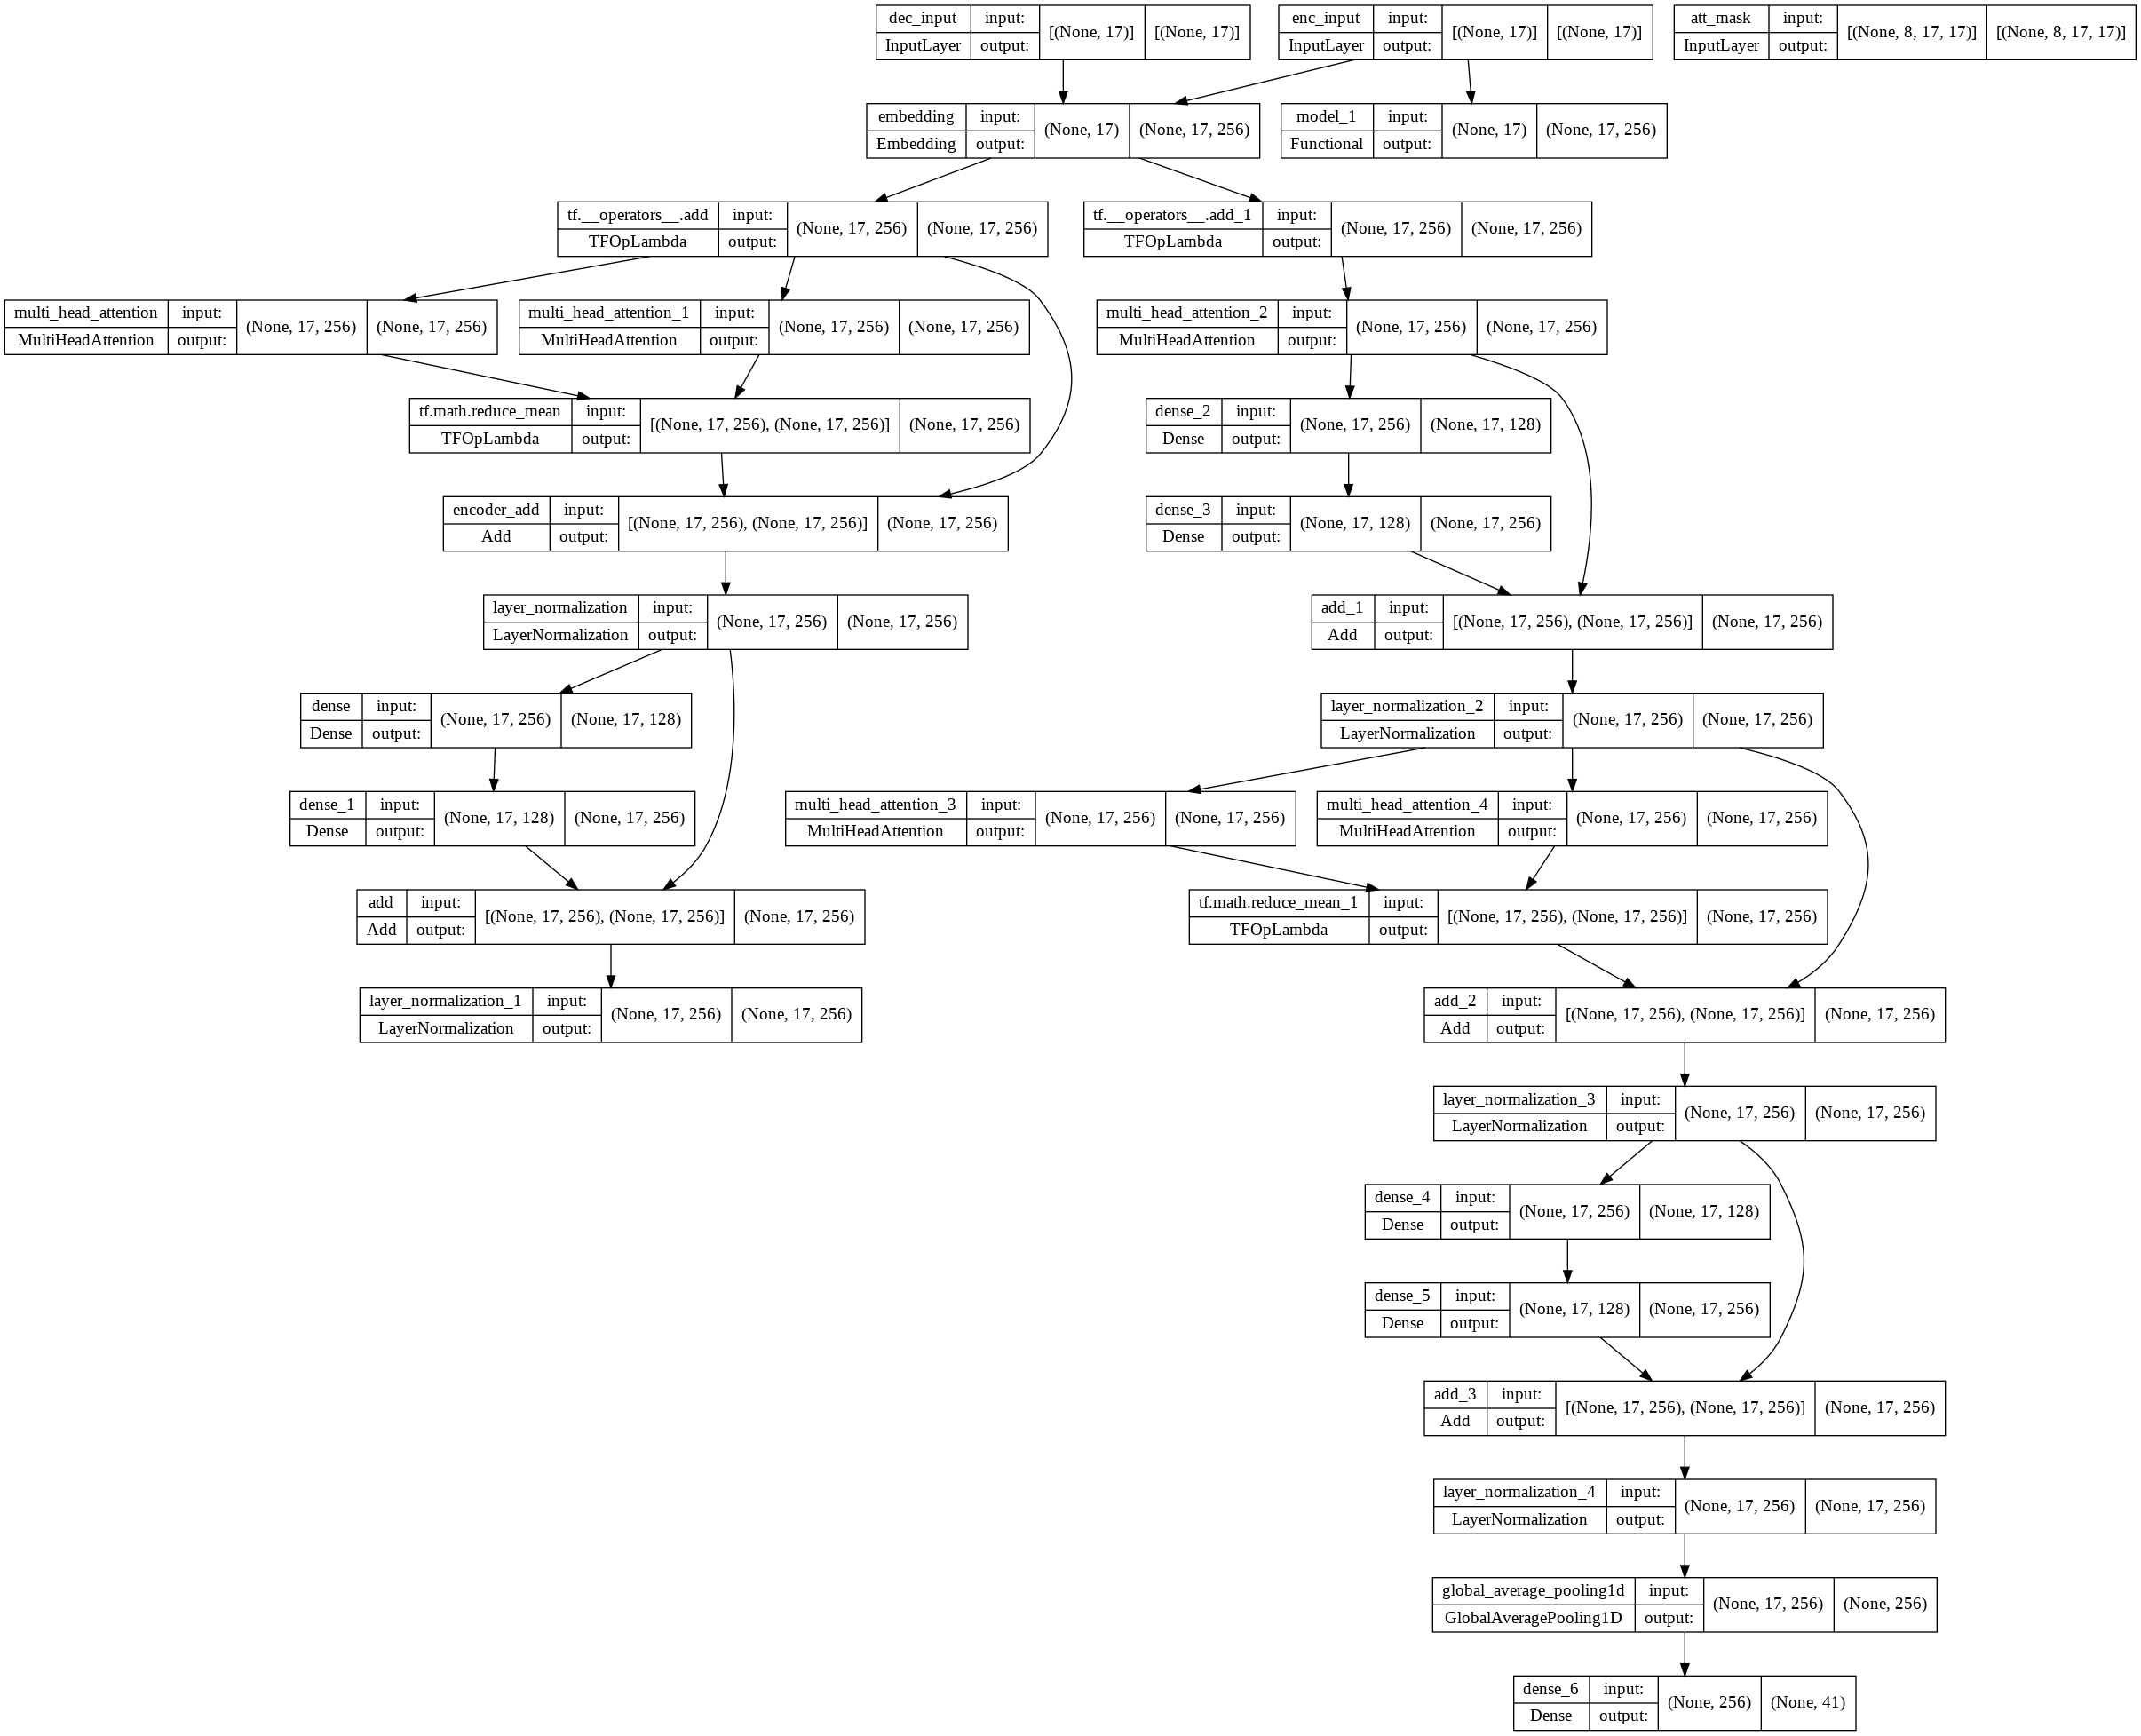

In [ ]:
# plot the model
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True)

# Custom Training

## GPU

In [ ]:
# construct attention masks list
# for each position there a mask that prevents the model from 
# see current and next positions
attention_masks = []
for i in range(1, config.MAXLEN+1):
  # Arabic masking starts from right to left
  attention_mask = [0] * (config.MAXLEN - i) + [1] * i
  attention_masks.append(attention_mask)

In [ ]:
# provide automatic class weights based on the inverse frequency 
# of each token, the more frequent, the less weight
total_num_labels = np.array(dec_indexed_text_train_labels).size
auto_weight_dict = dict()
for i in range(len(chars)+3):
  num_class_examples = (np.array(dec_indexed_text_train_labels) == i).sum()
  if num_class_examples != 0:
    auto_weight_dict[i] = total_num_labels / num_class_examples
  else:
    auto_weight_dict[i] = 0.1

auto_weight_dict[0] = 0.0 # give 'p' zero weight
auto_weight_dict

{0: 0.0,
 1: 17.0,
 2: 0.1,
 3: 15.992474129821261,
 4: 0.1,
 5: 95.50561797752809,
 6: 26.27511591962906,
 7: 459.4594594594595,
 8: 739.1304347826087,
 9: 184.7826086956522,
 10: 141.66666666666666,
 11: 354.1666666666667,
 12: 103.03030303030303,
 13: 1000.0,
 14: 54.83870967741935,
 15: 377.77777777777777,
 16: 112.58278145695364,
 17: 250.0,
 18: 204.81927710843374,
 19: 404.76190476190476,
 20: 204.81927710843374,
 21: 1133.3333333333333,
 22: 97.70114942528735,
 23: 653.8461538461538,
 24: 134.9206349206349,
 25: 107.59493670886076,
 26: 215.18987341772151,
 27: 76.57657657657657,
 28: 41.16222760290557,
 29: 50.89820359281437,
 30: 229.72972972972974,
 31: 66.40625,
 32: 41.46341463414634,
 33: 447.36842105263156,
 34: 1214.2857142857142,
 35: 118.88111888111888,
 36: 1416.6666666666667,
 37: 500.0,
 38: 340.0,
 39: 2125.0,
 40: 0.1}

In [ ]:
# !mv /content/best_full_model_weights.h5 /content/drive/MyDrive/NLP_Course

In [ ]:
# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))

# initialize the best accuracy at - infinity
best_result = -np.inf
# initialize the epoch of the best result as 0
epoch_of_best_result = 0
# initialize a variable for the current learning rate
current_learning = config.LEARNING_RATE
# for each epoch iterate over the whole training and validation sets
for epoch in range(config.EPOCHS):
  print(f'Epoch: {epoch+1}/{config.EPOCHS}')
  # iterate over the training dataset
  for batch in tqdm(train_ds, total=len(train_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # initialize losses and accuracies list
    losses = []
    accs = []
    top_accs = []
    # sequencially predict the label (actual previous token as input)
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # train on each batch and pass the class weights
      train_results = model.train_on_batch(x=(enc_inputs, dec_inputs, current_att_mask), y=labels[:, -(i+1)], 
                           class_weight=auto_weight_dict, reset_metrics=True, return_dict=True)
      # append the loss value
      losses.append(train_results['loss'])
      # append the accuracy value
      accs.append(train_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(train_results['top_k_acc'])
  print('Train loss:', np.mean(losses), 'Train accuracy', np.mean(accs), 'Train top 5 accuracy', np.mean(top_accs))

  # initialize losses and accuracies list
  losses = []
  accs = []
  top_accs = []
  # iterate over the validation dataset
  for batch in tqdm(valid_ds, total=len(valid_ds)):
    enc_inputs, dec_inputs, labels = batch
    # create a variable for the number of examples in the current batch
    num_examples = len(enc_inputs)
    # create a NumPy array to save the predictions of the previous tokens
    # it is initialized with ones where the model will see 1 in the first 
    # pass which represents the special starting "s" token
    full_sequence_preds = np.ones((num_examples, config.MAXLEN))
    # sequencially predict the label (predicted previous token as input (Auto-Regression))
    for i in range(config.MAXLEN):
      # extract the current mask from the attention_masks list
      # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
      current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
      # evaluate on each batch
      valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=True, return_dict=True)
      # predict the tokens of the current position
      preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
      # take the argmax value which represents the index of the highest prob character
      current_preds = np.argmax(preds, axis=-1)
      # populate the current position with the predicted values which will be used in the next 
      # pass as a decoder input
      full_sequence_preds[:, -(i+1)] = current_preds # populate the column of the current timestep with the predicitons
        
      # append the loss value  
      losses.append(valid_results['loss'])
      # append the accuracy value
      accs.append(valid_results['sparse_categorical_accuracy'])
      # append the top 5 accuracy value
      top_accs.append(valid_results['top_k_acc'])
  print('Valid loss:', np.mean(losses), 'Valid accuracy', np.mean(accs), 'Valid top 5 accuracy', np.mean(top_accs))

  mean_acc = np.mean(accs)
  # save the weights of the best model based on the validation accuracy
  # lower the LR a factor defined in the config class if the validation accuracy 
  # does not improve for the stated patience in the config class
  if mean_acc > best_result:
    best_result = mean_acc
    epoch_of_best_result = epoch
    print('Saving best model wieghts,', 'Accuracy:', mean_acc)
    model.save_weights('best_full_model_weights.h5')
  else:
    print("Accuracy didn't improve from:", best_result)
  if epoch - epoch_of_best_result == config.LEARTING_RATE_REDUCTION_PATIENCE:
    current_learning = current_learning * config.LEARTING_RATE_REDUCTION_FACTOR
    print("model didn't improve for 10 epochs---->", f"lower learning rate to {current_learning}")
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tf.keras.optimizers.Adam(learning_rate=current_learning))  

    

Epoch: 1/100


100%|██████████| 4/4 [00:16<00:00,  4.16s/it]


Train loss: 127.97184275528964 Train accuracy 0.02129817406153854 Train top 5 accuracy 0.11916835644446752


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


Valid loss: 5.164077099631815 Valid accuracy 0.01639885488240158 Valid top 5 accuracy 0.12076888967524557
Saving best model wieghts, Accuracy: 0.01639885488240158
Epoch: 2/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 121.33309630260749 Train accuracy 0.04361054712139508 Train top 5 accuracy 0.16227180801112862


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.767270228442023 Valid accuracy 0.0344127685050754 Valid top 5 accuracy 0.16092878470526023
Saving best model wieghts, Accuracy: 0.0344127685050754
Epoch: 3/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 118.08847816551433 Train accuracy 0.04056795152342495 Train top 5 accuracy 0.15111561892006328


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.172510034897748 Valid accuracy 0.03206875427242588 Valid top 5 accuracy 0.14232457527781234
Accuracy didn't improve from: 0.0344127685050754
Epoch: 4/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 111.2662624699228 Train accuracy 0.062373224728028566 Train top 5 accuracy 0.18230223332476966


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.004818705951466 Valid accuracy 0.058525080518687475 Valid top 5 accuracy 0.1658030134790084
Saving best model wieghts, Accuracy: 0.058525080518687475
Epoch: 5/100


100%|██████████| 4/4 [00:05<00:00,  1.29s/it]


Train loss: 103.44240155991386 Train accuracy 0.09051723942598876 Train top 5 accuracy 0.23047667308984435


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.782060111270232 Valid accuracy 0.03344743063344675 Valid top 5 accuracy 0.1358511348200195
Accuracy didn't improve from: 0.058525080518687475
Epoch: 6/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 83.69470385944142 Train accuracy 0.09406693756361217 Train top 5 accuracy 0.2122210941880065


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.27731509068433 Valid accuracy 0.08805965796551284 Valid top 5 accuracy 0.15968480618561015
Saving best model wieghts, Accuracy: 0.08805965796551284
Epoch: 7/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 78.24000861714867 Train accuracy 0.10167342838009491 Train top 5 accuracy 0.27053752305972223


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Valid loss: 6.138708303956425 Valid accuracy 0.07455285474219743 Valid top 5 accuracy 0.19434980226351933
Accuracy didn't improve from: 0.08805965796551284
Epoch: 8/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 56.105520251919245 Train accuracy 0.13209939085166245 Train top 5 accuracy 0.2707910742062856


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.201694222057567 Valid accuracy 0.11369855077389408 Valid top 5 accuracy 0.24328357211368926
Saving best model wieghts, Accuracy: 0.11369855077389408
Epoch: 9/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 56.83695651853786 Train accuracy 0.15618661084376714 Train top 5 accuracy 0.3204868144958335


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 6.654431735768037 Valid accuracy 0.08684869351632454 Valid top 5 accuracy 0.20435445054489024
Accuracy didn't improve from: 0.11369855077389408
Epoch: 10/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 47.16320315704626 Train accuracy 0.18458417964660945 Train top 5 accuracy 0.3364604456788477


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.1833730515311744 Valid accuracy 0.11215876557809465 Valid top 5 accuracy 0.2748439086272436
Accuracy didn't improve from: 0.11369855077389408
Epoch: 11/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 36.50747117750785 Train accuracy 0.21069979873102376 Train top 5 accuracy 0.3600405733484556


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.939499297562768 Valid accuracy 0.11146942602799219 Valid top 5 accuracy 0.24032945755650015
Accuracy didn't improve from: 0.11369855077389408
Epoch: 12/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 35.86845402331913 Train accuracy 0.20436105400543003 Train top 5 accuracy 0.3453346883658977


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.753849627340541 Valid accuracy 0.16312093265792904 Valid top 5 accuracy 0.32387275971910534
Saving best model wieghts, Accuracy: 0.16312093265792904
Epoch: 13/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 29.252053278334 Train accuracy 0.21450304119464228 Train top 5 accuracy 0.3635902631041758


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.283108912846622 Valid accuracy 0.16476240348728263 Valid top 5 accuracy 0.3413544835194069
Saving best model wieghts, Accuracy: 0.16476240348728263
Epoch: 14/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 29.597666549332 Train accuracy 0.20943205085966518 Train top 5 accuracy 0.35167342670919266


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.500302330536001 Valid accuracy 0.17823355086147785 Valid top 5 accuracy 0.3334733131615555
Saving best model wieghts, Accuracy: 0.17823355086147785
Epoch: 15/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 33.31182384841583 Train accuracy 0.18661257367142858 Train top 5 accuracy 0.35116632485433535


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Valid loss: 6.511090855388081 Valid accuracy 0.17670036918100188 Valid top 5 accuracy 0.32488035717431235
Accuracy didn't improve from: 0.17823355086147785
Epoch: 16/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 19.500879012486514 Train accuracy 0.24543610957505949 Train top 5 accuracy 0.3841277920257519


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 6.070344944210613 Valid accuracy 0.21654860697248401 Valid top 5 accuracy 0.35525877675151124
Saving best model wieghts, Accuracy: 0.21654860697248401
Epoch: 17/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 19.665140213335263 Train accuracy 0.2449290045427487 Train top 5 accuracy 0.36967545906629634


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 6.129207959946464 Valid accuracy 0.2032187609549831 Valid top 5 accuracy 0.3443350124665919
Accuracy didn't improve from: 0.21654860697248401
Epoch: 18/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 22.123834820354688 Train accuracy 0.2342799188952674 Train top 5 accuracy 0.37322515199947004


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.76735510896234 Valid accuracy 0.1811546526630135 Valid top 5 accuracy 0.33100516414817643
Accuracy didn't improve from: 0.21654860697248401
Epoch: 19/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 24.29247241686372 Train accuracy 0.21348884400418577 Train top 5 accuracy 0.34153144132784186


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.262900458539233 Valid accuracy 0.197153375538833 Valid top 5 accuracy 0.3581178149975398
Accuracy didn't improve from: 0.21654860697248401
Epoch: 20/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 23.448644939590903 Train accuracy 0.2641987834290108 Train top 5 accuracy 0.37905679418541055


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Valid loss: 6.356188164037817 Valid accuracy 0.18233920776230447 Valid top 5 accuracy 0.31993349455296993
Accuracy didn't improve from: 0.21654860697248401
Epoch: 21/100


100%|██████████| 4/4 [00:05<00:00,  1.45s/it]


Train loss: 16.808546101345737 Train accuracy 0.2634381324819782 Train top 5 accuracy 0.3818458422251484


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Valid loss: 6.289570711114827 Valid accuracy 0.19553435550016515 Valid top 5 accuracy 0.33359480452011614
Accuracy didn't improve from: 0.21654860697248401
Epoch: 22/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 15.139001474660986 Train accuracy 0.28600405994802713 Train top 5 accuracy 0.3904665316838552


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.327130774364752 Valid accuracy 0.18997078958679647 Valid top 5 accuracy 0.3328367980087505
Accuracy didn't improve from: 0.21654860697248401
Epoch: 23/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 16.292107920436298 Train accuracy 0.2639452334602966 Train top 5 accuracy 0.38311359445180965


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Valid loss: 6.677127673345454 Valid accuracy 0.1825795515495188 Valid top 5 accuracy 0.3327417177531649
Accuracy didn't improve from: 0.21654860697248401
Epoch: 24/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 12.949638363193063 Train accuracy 0.2776369188145241 Train top 5 accuracy 0.38970588218859015


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 6.341454336748404 Valid accuracy 0.24485901502125404 Valid top 5 accuracy 0.36751500067903714
Saving best model wieghts, Accuracy: 0.24485901502125404
Epoch: 25/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 16.35349565569092 Train accuracy 0.2479716059203972 Train top 5 accuracy 0.3630831613588859


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 6.510765829507043 Valid accuracy 0.20294672316488097 Valid top 5 accuracy 0.3538734995047836
Accuracy didn't improve from: 0.24485901502125404
Epoch: 26/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 12.2254159450531 Train accuracy 0.32175456464071484 Train top 5 accuracy 0.39579107464455504


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.347281368339763 Valid accuracy 0.21366316025309703 Valid top 5 accuracy 0.347167637966135
Accuracy didn't improve from: 0.24485901502125404
Epoch: 27/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 11.893744659774443 Train accuracy 0.2976673408685362 Train top 5 accuracy 0.3935091283501071


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.467278533122119 Valid accuracy 0.2254400137154495 Valid top 5 accuracy 0.3400022174943896
Accuracy didn't improve from: 0.24485901502125404
Epoch: 28/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 10.506075650453568 Train accuracy 0.3108519248335677 Train top 5 accuracy 0.39300202605698037


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 6.453602410414639 Valid accuracy 0.21938783478210955 Valid top 5 accuracy 0.3606942494345062
Accuracy didn't improve from: 0.24485901502125404
Epoch: 29/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 12.087583387599272 Train accuracy 0.3111054794041111 Train top 5 accuracy 0.38488844108274756


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 5.975155148436041 Valid accuracy 0.223848725833437 Valid top 5 accuracy 0.36253248439992175
Accuracy didn't improve from: 0.24485901502125404
Epoch: 30/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 9.502548529821283 Train accuracy 0.3255578112678931 Train top 5 accuracy 0.3970588233650607


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.2257858041454766 Valid accuracy 0.21495995955432162 Valid top 5 accuracy 0.3563350440167329
Accuracy didn't improve from: 0.24485901502125404
Epoch: 31/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 9.70585536255556 Train accuracy 0.3138945224311422 Train top 5 accuracy 0.3983265720855664


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.628015016808229 Valid accuracy 0.20781038854928577 Valid top 5 accuracy 0.3417942326735048
Accuracy didn't improve from: 0.24485901502125404
Epoch: 32/100


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Train loss: 9.973901647855254 Train accuracy 0.3012170401018332 Train top 5 accuracy 0.385141987408347


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.26087771180798 Valid accuracy 0.25034070814795356 Valid top 5 accuracy 0.36875237929908666
Saving best model wieghts, Accuracy: 0.25034070814795356
Epoch: 33/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 8.019884151570936 Train accuracy 0.3126267730532324 Train top 5 accuracy 0.39274847491041703


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.234700359842357 Valid accuracy 0.25327501588446255 Valid top 5 accuracy 0.36807624491698604
Saving best model wieghts, Accuracy: 0.25327501588446255
Epoch: 34/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 6.440454232342103 Train accuracy 0.33189655281603336 Train top 5 accuracy 0.3968052722184974


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Valid loss: 6.275198974153575 Valid accuracy 0.2534427309737486 Valid top 5 accuracy 0.36388475075364113
Saving best model wieghts, Accuracy: 0.2534427309737486
Epoch: 35/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 7.621799030724694 Train accuracy 0.3154158220242928 Train top 5 accuracy 0.39325557369738817


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.605189958039452 Valid accuracy 0.23075795381823005 Valid top 5 accuracy 0.3577203236739425
Accuracy didn't improve from: 0.2534427309737486
Epoch: 36/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 10.321926809409085 Train accuracy 0.2920892545405556 Train top 5 accuracy 0.39401622713707823


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.6226348824360795 Valid accuracy 0.23149615591939757 Valid top 5 accuracy 0.35078468283309655
Accuracy didn't improve from: 0.2534427309737486
Epoch: 37/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 8.497015781262341 Train accuracy 0.304766733363709 Train top 5 accuracy 0.3940162236309227


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Valid loss: 6.498488421825802 Valid accuracy 0.25760781315757947 Valid top 5 accuracy 0.369792987647302
Saving best model wieghts, Accuracy: 0.25760781315757947
Epoch: 38/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 7.029054752167533 Train accuracy 0.3324036511647351 Train top 5 accuracy 0.3968052722184974


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Valid loss: 6.360583336037748 Valid accuracy 0.2538296574836268 Valid top 5 accuracy 0.3646823766038698
Accuracy didn't improve from: 0.25760781315757947
Epoch: 39/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 5.841348092345631 Train accuracy 0.3392494931981406 Train top 5 accuracy 0.39781946979243965


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Valid loss: 6.1896933974588615 Valid accuracy 0.24687156683820136 Valid top 5 accuracy 0.36365497276625214
Accuracy didn't improve from: 0.25760781315757947
Epoch: 40/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 5.710895122850642 Train accuracy 0.3296146022210665 Train top 5 accuracy 0.39756592215203185


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Valid loss: 6.47977290258688 Valid accuracy 0.22470181281952298 Valid top 5 accuracy 0.3483852051636752
Accuracy didn't improve from: 0.25760781315757947
Epoch: 41/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 9.931283497635055 Train accuracy 0.3055273845024845 Train top 5 accuracy 0.39300202386563315


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.953847506467034 Valid accuracy 0.21444757775787046 Valid top 5 accuracy 0.34542448380414176
Accuracy didn't improve from: 0.25760781315757947
Epoch: 42/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 26.998451070750463 Train accuracy 0.2685091295553481 Train top 5 accuracy 0.38767748134320273


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.630982041358948 Valid accuracy 0.09843538734404479 Valid top 5 accuracy 0.2545520089128438
Accuracy didn't improve from: 0.25760781315757947
Epoch: 43/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 20.53058402722373 Train accuracy 0.27383366703767986 Train top 5 accuracy 0.3782961437040392


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.347500043756821 Valid accuracy 0.18137519039651928 Valid top 5 accuracy 0.3384399820557412
Accuracy didn't improve from: 0.25760781315757947
Epoch: 44/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 6.808073739795124 Train accuracy 0.33671399167574506 Train top 5 accuracy 0.3973123674993129


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Valid loss: 6.499850827981444 Valid accuracy 0.2213237948496552 Valid top 5 accuracy 0.3639930369442
Accuracy didn't improve from: 0.25760781315757947
Epoch: 45/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 5.319743694627986 Train accuracy 0.3552231205462971 Train top 5 accuracy 0.39858012323212977


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 6.536847185562639 Valid accuracy 0.21606923847952308 Valid top 5 accuracy 0.3628639502122122
Accuracy didn't improve from: 0.25760781315757947
Epoch: 46/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 6.4084592584301445 Train accuracy 0.34026369164862175 Train top 5 accuracy 0.3983265720855664


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.643222961355658 Valid accuracy 0.19326693422215827 Valid top 5 accuracy 0.3504598217413706
Accuracy didn't improve from: 0.25760781315757947
Epoch: 47/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 4.777216421330676 Train accuracy 0.3524340745609473 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.643133770017063 Valid accuracy 0.23572726646328673 Valid top 5 accuracy 0.36490555337684993
Accuracy didn't improve from: 0.25760781315757947
model didn't improve for 10 epochs----> lower learning rate to 2e-05
Epoch: 48/100


100%|██████████| 4/4 [00:11<00:00,  2.80s/it]


Train loss: 3.962093710022814 Train accuracy 0.36080121824189143 Train top 5 accuracy 0.39858012323212977


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


Valid loss: 6.517228695399621 Valid accuracy 0.23663978015675263 Valid top 5 accuracy 0.36160676553845406
Accuracy didn't improve from: 0.25760781315757947
Epoch: 49/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 3.6982387558502308 Train accuracy 0.3656186602242729 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Valid loss: 6.491478489602313 Valid accuracy 0.23802506036179907 Valid top 5 accuracy 0.36240439138868275
Accuracy didn't improve from: 0.25760781315757947
Epoch: 50/100


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Train loss: 3.536490136209656 Train accuracy 0.3658722096177585 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Valid loss: 6.429177393808084 Valid accuracy 0.23632152279948487 Valid top 5 accuracy 0.3610389199765289
Accuracy didn't improve from: 0.25760781315757947
Epoch: 51/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 3.531979501247406 Train accuracy 0.3648580120438162 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Valid loss: 6.4153974967844345 Valid accuracy 0.24233804577413728 Valid top 5 accuracy 0.361944832455586
Accuracy didn't improve from: 0.25760781315757947
Epoch: 52/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.2321264533435596 Train accuracy 0.3666328563738395 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.533536100212266 Valid accuracy 0.25109871367321296 Valid top 5 accuracy 0.36501384088221717
Accuracy didn't improve from: 0.25760781315757947
Epoch: 53/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 3.1603841264458263 Train accuracy 0.36587220863165226 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Valid loss: 6.583328791400966 Valid accuracy 0.24656915511278546 Valid top 5 accuracy 0.36284413889927025
Accuracy didn't improve from: 0.25760781315757947
Epoch: 54/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 3.078034880406716 Train accuracy 0.3666328563738395 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.602331051055123 Valid accuracy 0.24271572972921765 Valid top 5 accuracy 0.363175603615887
Accuracy didn't improve from: 0.25760781315757947
Epoch: 55/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 3.0198777712443294 Train accuracy 0.3696754561079776 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.67589794011677 Valid accuracy 0.23109602205017032 Valid top 5 accuracy 0.3595321477555177
Accuracy didn't improve from: 0.25760781315757947
Epoch: 56/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 3.1881668484386276 Train accuracy 0.3719574057990137 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.700613366330371 Valid accuracy 0.23406334539108417 Valid top 5 accuracy 0.35909239958752603
Accuracy didn't improve from: 0.25760781315757947
Epoch: 57/100


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Train loss: 2.7074416367446674 Train accuracy 0.37373225166298013 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Valid loss: 6.498609560377457 Valid accuracy 0.24897523695493445 Valid top 5 accuracy 0.3638715460239088
Accuracy didn't improve from: 0.25760781315757947
Epoch: 58/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.8122961976948906 Train accuracy 0.37068965543499766 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Valid loss: 6.578077258432613 Valid accuracy 0.25153846721000533 Valid top 5 accuracy 0.36262756618945036
Accuracy didn't improve from: 0.25760781315757947
Epoch: 59/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 2.361103805110735 Train accuracy 0.37373225210124955 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.659867386607563 Valid accuracy 0.250320898478522 Valid top 5 accuracy 0.3622828989344485
Accuracy didn't improve from: 0.25760781315757947
Epoch: 60/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.361938988461214 Train accuracy 0.37373224990990234 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Valid loss: 6.666923681602759 Valid accuracy 0.24932650805396192 Valid top 5 accuracy 0.362844140652348
Accuracy didn't improve from: 0.25760781315757947
Epoch: 61/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 2.265750712769873 Train accuracy 0.3744928985286285 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Valid loss: 6.649812510784934 Valid accuracy 0.2549719497123185 Valid top 5 accuracy 0.36126209576340285
Accuracy didn't improve from: 0.25760781315757947
Epoch: 62/100


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Train loss: 2.190360266934423 Train accuracy 0.376774848329232 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.606626108288765 Valid accuracy 0.25359327488524075 Valid top 5 accuracy 0.36057275917161913
Accuracy didn't improve from: 0.25760781315757947
Epoch: 63/100


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Train loss: 2.242570500163471 Train accuracy 0.3777890472179827 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Valid loss: 6.569809860166381 Valid accuracy 0.24508879563825972 Valid top 5 accuracy 0.36147866945932894
Accuracy didn't improve from: 0.25760781315757947
Epoch: 64/100


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Train loss: 2.261670426410787 Train accuracy 0.3793103488381295 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Valid loss: 6.589899715255289 Valid accuracy 0.24198677357943618 Valid top 5 accuracy 0.3604578682604958
Accuracy didn't improve from: 0.25760781315757947
Epoch: 65/100


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Train loss: 2.258467024740051 Train accuracy 0.38083163851543383 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Valid loss: 6.839673166765886 Valid accuracy 0.23611155031796763 Valid top 5 accuracy 0.35728057364330573
Accuracy didn't improve from: 0.25760781315757947
Epoch: 66/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 2.492903994725031 Train accuracy 0.3760141987243996 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Valid loss: 6.905668590875233 Valid accuracy 0.24825948761666522 Valid top 5 accuracy 0.3612488898284295
Accuracy didn't improve from: 0.25760781315757947
Epoch: 67/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.8427077917491688 Train accuracy 0.378296141512692 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.835427633979741 Valid accuracy 0.2566754876033348 Valid top 5 accuracy 0.3623779798474382
Accuracy didn't improve from: 0.25760781315757947
Epoch: 68/100


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Train loss: 1.9495364760651308 Train accuracy 0.3739858050008907 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Valid loss: 6.776687146986232 Valid accuracy 0.25723673074561004 Valid top 5 accuracy 0.36262096563244567
Accuracy didn't improve from: 0.25760781315757947
Epoch: 69/100


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Train loss: 1.8222984377952183 Train accuracy 0.37702839772271757 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Valid loss: 6.750618747052024 Valid accuracy 0.26117863604689345 Valid top 5 accuracy 0.36396662660819645
Saving best model wieghts, Accuracy: 0.26117863604689345
Epoch: 70/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 1.6525905496057343 Train accuracy 0.3820993911803645 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 6.756056733867702 Valid accuracy 0.2573516196845209 Valid top 5 accuracy 0.3623911846867379
Accuracy didn't improve from: 0.26117863604689345
Epoch: 71/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.5656753721482612 Train accuracy 0.38438133747481246 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.779560822774382 Valid accuracy 0.25574316292562904 Valid top 5 accuracy 0.3612488907049684
Accuracy didn't improve from: 0.26117863604689345
Epoch: 72/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 1.5593051524723278 Train accuracy 0.3853955350487548 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.827606118777219 Valid accuracy 0.2547091554631205 Valid top 5 accuracy 0.36214159648208055
Accuracy didn't improve from: 0.26117863604689345
Epoch: 73/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.7689747389625101 Train accuracy 0.3810851896619972 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 6.986982982824831 Valid accuracy 0.2488827965057948 Valid top 5 accuracy 0.36010659617536206
Accuracy didn't improve from: 0.26117863604689345
Epoch: 74/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 4.2221491123166155 Train accuracy 0.34330628795877977 Train top 5 accuracy 0.3990872220191009


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


Valid loss: 7.312617266002824 Valid accuracy 0.25273358230205145 Valid top 5 accuracy 0.3577269272988333
Accuracy didn't improve from: 0.26117863604689345
Epoch: 75/100


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Train loss: 1.709156702108243 Train accuracy 0.38083164169288736 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Valid loss: 6.994192976285429 Valid accuracy 0.2604140255819349 Valid top 5 accuracy 0.3627358554478954
Accuracy didn't improve from: 0.26117863604689345
Epoch: 76/100


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Train loss: 1.4273064870606451 Train accuracy 0.3851419909145026 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.9412218779325485 Valid accuracy 0.2599478628048125 Valid top 5 accuracy 0.3622630890458822
Accuracy didn't improve from: 0.26117863604689345
Epoch: 77/100


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Train loss: 1.3628220231655765 Train accuracy 0.38615618848844485 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.9182980893289345 Valid accuracy 0.2594949078253087 Valid top 5 accuracy 0.3613637803012834
Accuracy didn't improve from: 0.26117863604689345
Epoch: 78/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 1.3117196380215532 Train accuracy 0.38666328376926046 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.905721186715014 Valid accuracy 0.26050250177436013 Valid top 5 accuracy 0.3616952452370349
Accuracy didn't improve from: 0.26117863604689345
Epoch: 79/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 1.2683849724776604 Train accuracy 0.3869168349158238 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Valid loss: 6.90026910164777 Valid accuracy 0.26164479685180325 Valid top 5 accuracy 0.3610191129367141
Saving best model wieghts, Accuracy: 0.26164479685180325
Epoch: 80/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 1.2317160766790896 Train accuracy 0.38666328376926046 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.9178520458586075 Valid accuracy 0.25937341460410285 Valid top 5 accuracy 0.36011980419211526
Accuracy didn't improve from: 0.26164479685180325
Epoch: 81/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 1.2150347193374353 Train accuracy 0.38640973262269707 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Valid loss: 6.903860669802217 Valid accuracy 0.25827734040863376 Valid top 5 accuracy 0.35945027310620337
Accuracy didn't improve from: 0.26164479685180325
Epoch: 82/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.3155351785175942 Train accuracy 0.38286004111389904 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Valid loss: 6.879636207047631 Valid accuracy 0.2555041400825276 Valid top 5 accuracy 0.36070745668428783
Accuracy didn't improve from: 0.26164479685180325
Epoch: 83/100


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Train loss: 1.5741475494030643 Train accuracy 0.3760141969713218 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Valid loss: 6.889425065587549 Valid accuracy 0.2556190314319204 Valid top 5 accuracy 0.3611538105589502
Accuracy didn't improve from: 0.26164479685180325
Epoch: 84/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.15333288316341 Train accuracy 0.38767748134320273 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 6.9485893591361885 Valid accuracy 0.26425424700274186 Valid top 5 accuracy 0.36055955312707844
Saving best model wieghts, Accuracy: 0.26425424700274186
Epoch: 85/100


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Train loss: 1.3022562721196342 Train accuracy 0.390720083268688 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Valid loss: 7.124832807218327 Valid accuracy 0.23454931542715607 Valid top 5 accuracy 0.3516905953121536
Accuracy didn't improve from: 0.26425424700274186
Epoch: 86/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 1.4980082632425953 Train accuracy 0.3856490861953181 Train top 5 accuracy 0.39959432080607205


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Valid loss: 7.283444544848273 Valid accuracy 0.2454598772832576 Valid top 5 accuracy 0.3546447158955476
Accuracy didn't improve from: 0.26425424700274186
Epoch: 87/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 1.0097987347227686 Train accuracy 0.3899594276376507 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.069405612700126 Valid accuracy 0.26304988442536664 Valid top 5 accuracy 0.3609042213681866
Accuracy didn't improve from: 0.26425424700274186
Epoch: 88/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 1.0823817014255945 Train accuracy 0.3856490897014737 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Valid loss: 7.123964166816543 Valid accuracy 0.264185577411862 Valid top 5 accuracy 0.3603495826177737
Accuracy didn't improve from: 0.26425424700274186
Epoch: 89/100


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Train loss: 0.9952598766368979 Train accuracy 0.38793103248976607 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Valid loss: 7.112678092192201 Valid accuracy 0.261710826855372 Valid top 5 accuracy 0.3601198006859597
Accuracy didn't improve from: 0.26425424700274186
Epoch: 90/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.9123175082837834 Train accuracy 0.39021297878421407 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


Valid loss: 7.021929289488232 Valid accuracy 0.2607983133810408 Valid top 5 accuracy 0.36021488324245987
Accuracy didn't improve from: 0.26425424700274186
Epoch: 91/100


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Train loss: 0.8832087116863798 Train accuracy 0.3919878262916909 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.016379387063139 Valid accuracy 0.2580607689040549 Valid top 5 accuracy 0.35918748148662205
Accuracy didn't improve from: 0.26425424700274186
Epoch: 92/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 0.8637961839490077 Train accuracy 0.3937626759905149 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


Valid loss: 7.036232638008454 Valid accuracy 0.25478178843417587 Valid top 5 accuracy 0.3578286112888771
Accuracy didn't improve from: 0.26425424700274186
Epoch: 93/100


100%|██████████| 4/4 [00:10<00:00,  2.56s/it]


Train loss: 0.8595709227682913 Train accuracy 0.3942697782836416 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


Valid loss: 7.076580582296147 Valid accuracy 0.250380323980661 Valid top 5 accuracy 0.35760543604984
Accuracy didn't improve from: 0.26425424700274186
Epoch: 94/100


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Train loss: 0.8504443536786472 Train accuracy 0.39477687707061276 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.07576679920449 Valid accuracy 0.2465070894754985 Valid top 5 accuracy 0.35771372092559056
Accuracy didn't improve from: 0.26425424700274186
model didn't improve for 10 epochs----> lower learning rate to 4.000000000000001e-06
Epoch: 95/100


100%|██████████| 4/4 [00:20<00:00,  5.12s/it]


Train loss: 0.7535577836062979 Train accuracy 0.3937626737991677 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:10<00:00,  5.11s/it]


Valid loss: 7.1135798385914635 Valid accuracy 0.25988579486661095 Valid top 5 accuracy 0.35976853123044267
Accuracy didn't improve from: 0.26425424700274186
Epoch: 96/100


100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Train loss: 0.7449733397430357 Train accuracy 0.3942697725861388 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.1005629152059555 Valid accuracy 0.25988579486661095 Valid top 5 accuracy 0.3599917085512596
Accuracy didn't improve from: 0.26425424700274186
Epoch: 97/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 0.7364472214351682 Train accuracy 0.39477687137310996 Train top 5 accuracy 0.39934076965950865


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Valid loss: 7.088545949143522 Valid accuracy 0.26056192979654846 Valid top 5 accuracy 0.36044466440730233
Accuracy didn't improve from: 0.26425424700274186
Epoch: 98/100


100%|██████████| 4/4 [00:05<00:00,  1.34s/it]


Train loss: 0.7275668966638691 Train accuracy 0.39477687137310996 Train top 5 accuracy 0.39959432080607205


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Valid loss: 7.081634412793552 Valid accuracy 0.2600006845724933 Valid top 5 accuracy 0.36033637679236774
Accuracy didn't improve from: 0.26425424700274186
Epoch: 99/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 0.7185013476101791 Train accuracy 0.3952839723514283 Train top 5 accuracy 0.39959432080607205


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Valid loss: 7.079237974741879 Valid accuracy 0.2600006845724933 Valid top 5 accuracy 0.36033637679236774
Accuracy didn't improve from: 0.26425424700274186
Epoch: 100/100


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


Train loss: 0.709389507989673 Train accuracy 0.3952839723514283 Train top 5 accuracy 0.39959432080607205


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

Valid loss: 7.078135088086128 Valid accuracy 0.2596626192988718 Valid top 5 accuracy 0.3599983115187463
Accuracy didn't improve from: 0.26425424700274186


## Prediction

In [ ]:
# construct attention masks list
# for each position there a mask that prevents the model from 
# see current and next positions
attention_masks = []
for i in range(1, config.MAXLEN+1):
  # Arabic masking starts from right to left
  attention_mask = [0] * (config.MAXLEN - i) + [1] * i
  attention_masks.append(attention_mask)

In [ ]:
# define the loss object (SparseCategoricalCrossentropy)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

def gradients(enc_inputs, full_sequence_preds, current_att_mask, y):
  '''
  Inputs: 
      enc_inputs: array of the inputs to the encoder and CBERT (only one sample (batched))
      full_sequence_preds: array of the inputs to the decoder (only one sample (batched))
      current_att_mask: array of the mask to be used in the decoder (only one sample (batched))

  Returns:
      input_ids: an array of the ids inputted to CBERT, encoder, and decoder
      grads: gradients retrieved by the backporpagation with respect to the embeddings of the input_ids
  '''

  # tape the forward pass and loss computation
  with tf.GradientTape() as tape:
    preds = model((enc_inputs, full_sequence_preds, current_att_mask), training=False)
    loss = loss_object(y, preds)

  # compute the gradients with respect to the model's trainable weights
  gradients = tape.gradient(loss, model.trainable_weights)

  # extract the input_ids
  decoder_input_ids = gradients[0].indices.numpy()[:17]
  encoder_input_ids = gradients[0].indices.numpy()[17:17*2]
  cbert_input_ids = gradients[0].indices.numpy()[17*2:17*3]

  # extract the gradients with respect to the embeddings
  decoder_grads = gradients[0].values.numpy()[:17, :]
  encoder_grads = gradients[0].values.numpy()[17:17*2, :]
  cbert_grads = gradients[0].values.numpy()[17*2:17*3, :]

  # build a dictionary with the input_ids and gradients for each of the parts in the model
  input_ids = {'cbert_input_ids': cbert_input_ids, 'encoder_input_ids': encoder_input_ids, 'decoder_input_ids': decoder_input_ids}
  grads = {'cbert_grads': cbert_grads, 'encoder_grads': encoder_grads, 'decoder_grads': decoder_grads}

  return (input_ids, grads)

In [ ]:
# unbatch the validation dataset and re-batch it with a batch size of 1
valid_ds = valid_ds.unbatch().batch(1)

# clear the session to release all previous states generated by Keras
tf.keras.backend.clear_session()
# instantiate and compile the model inside the strategy scope defined previous
with strategy.scope():
  model = encoder_decoder_model()
  model.trainable = True # <<<<<<<<<<<<<<<
  # use Sparse Categorical Cross-entropy as a loss function as labels are not one-hot encoded
  # use AdamW optimizer initially with a weight decay of 0.0
  # use the Sparse Categorical Accuracy and top k=5 accuracy metrics to monitor and save the best model weights
  metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),
             tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_k_acc')]
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=metrics,
                optimizer=tfa.optimizers.AdamW(learning_rate=config.LEARNING_RATE, weight_decay=0.0))
  # load_weights of best performing model
  model.load_weights('/content/best_full_model_weights.h5')

# create a dictionary to hold the gradienst of all samples
all_examples_dict = dict() 
# iterate over the validation dataset
for iteration, batch in enumerate(tqdm(valid_ds, total=len(valid_df))):
  # for each sample create a dictionary to hold the gradients of all passes
  all_examples_dict[f'example_{iteration}'] = dict()
  enc_inputs, dec_inputs, labels = batch
  # create a variable for the number of examples in the current batch
  num_examples = len(enc_inputs)
  # create a NumPy array to save the predictions of the previous tokens
  # it is initialized with ones where the model will see 1 in the first 
  # pass which represents the special starting "s" token
  full_sequence_preds = np.ones((num_examples, config.MAXLEN))
  # sequencially predict the label (predicted previous token as input (Auto-Regression))
  for i in range(config.MAXLEN):
    # extract the current mask from the attention_masks list
    # broadcast the mask to the shape of (num_examples, num_heads(8), max_len(17), max_len(17))
    current_att_mask = tf.broadcast_to(tf.constant(attention_masks[i]), (num_examples, config.NUM_HEADS, config.MAXLEN, config.MAXLEN))
    # evaluate on each batch
    
    # interpretibility part
    y = labels[:, -(i+1)] # extract the labels of the current pass
    # use the gradients function to extract the gradiens w.r.t. the inputs to CBERT, encoder, and decoder
    input_ids, grads = gradients(enc_inputs, full_sequence_preds, current_att_mask, y)
    all_examples_dict[f'example_{iteration}'][f'pass_{i}'] = (input_ids, grads)

    valid_results = model.test_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask), y=labels[:, -(i+1)], reset_metrics=False, return_dict=True)
    # predict the tokens of the current position
    preds = model.predict_on_batch(x=(enc_inputs, full_sequence_preds, current_att_mask))
    # take the argmax value which represents the index of the highest prob character
    current_preds = np.argmax(preds, axis=-1)
    # populate the current position with the predicted values which will be used in the next 
    # pass as a decoder input
    full_sequence_preds[:, -(i+1)] = current_preds

  if iteration == 0:
    final_full_sequence_preds = full_sequence_preds
  else: # concatenate the preditions to form the final model predictions
    final_full_sequence_preds = np.concatenate([final_full_sequence_preds, full_sequence_preds], axis=0)

100%|██████████| 343/343 [16:21<00:00,  2.86s/it]


In [ ]:
# save the gradients dictionary into a pickle file
with open('interpritibility_grads.pkl', 'wb') as f:
  pickle.dump(all_examples_dict, f)

# !mv /content/interpritibility_grads.pkl /content/drive/MyDrive/NLP_Course

In [ ]:
# save the predictions as a NumPy array
np.save('validation_set_prediction_with_interpretibility.npy', final_full_sequence_preds)
# !mv /content/validation_set_prediction_with_interpretibility.npy /content/drive/MyDrive/NLP_Course